<p align = "center"><strong>LOCAL SPATIAL AUTOCORRELATION: MORAN’S I <strong></p>

<p><b>By: Jefferson C.</p>

---

#### __Bivariate Local Moran's Index__

__Def.__

Medida **local de autocorrelación espacial** que cuantifica el grado en que el valor de una variable en una unidad espacial está asociado con los valores de las unidades espaciales vecinas, de acuerdo con una matriz de pesos espaciales.

El índice toma los siguientes valores:
- $\to$ __positivo__ cuando existe asociación espacial positiva (valores similares).
- $\approx$ __0__ cuando NO hay autocorrelación espacial local.
- $\to$ __negativo__ cuando existe asociación espacial negativa (valores disímiles).

__Formula:__

Desviaciones respecto a la media:
$$
z_i = x_i - \bar{x} \quad z_j = x_j - \bar{x} \quad \bar{x} = \frac{1}{n} \sum_{i=1}^{n} x_i
$$ 

Índice de Moran Bivariado Local:
$$
I_i = z_i \sum_{j=1}^{n} w_{ij} z_j
$$

<p align='center'> 
<em>El índice de Moran Local permite identificar clústeres espaciales y valores atípicos espaciales, descomponiendo la autocorrelación espacial global en contribuciones individuales.</em>
</p>

donde:
- $w_{ij}$: elemento de la matriz de pesos espaciales $W$,
- $x_i$: valor observado de la variable de interés en la unidad espacial $i$,
- $x_j$: valor observado de la variable de interés en la unidad espacial contigua (vecina de $x_i$),
- $n$: número de unidades espaciales,
- $z_i$: valor centrado (no normalizado) de la observación $i$.

__Referencia:__
- Anselin, L. (1995). *Local Indicators of Spatial Association—LISA*. Geographical Analysis, 27(2), 93–115.  
  https://doi.org/10.1111/j.1538-4632.1995.tb00338.x


In [14]:
# DEPENDENCIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
    # Import data (shp)
import geopandas as gpd
    # Weight Matrix
from libpysal.weights import Queen, Rook, W, lag_spatial
    # Global and Local Bivariate Moran
from esda.moran import Moran_BV, Moran_Local_BV
    # Warnings
import warnings


def local_moran_bv(
    gdf,
    x_fields,
    y_fields,
    contiguities=("queen", "rook", "bishop"),
    permutations: int = 999,
    alpha: float = 0.05,
    drop_islands: bool = True,
    standardize_xy: bool = True,
    use_index: bool = True,
    figsize=(18, 12),
    style: str = "seaborn-v0_8",
    silence_warnings: bool = True,
    dashboard_pair: tuple[str, str] | None = None,
):
    """
    Local Moran Bivariado (LISA BV) para múltiples pares (X,Y) y 3 contigüidades (Queen/Rook/Bishop).
    
    Uses esda.moran.Moran_Local_BV para el cálculo del estadístico bivariado local.
    
    Returns:
      - results_table: tabla con Moran Global BV + LISA BV counts (por par x contiguity)
      - fig: Dashboard para UN par (dashboard_pair):
             (1) Moran scatter bivariado: z(x) vs lag(z(y))
             (2) LISA BV significance map (p bins)
             (3) LISA BV cluster map (HH, LL, LH, HL)
             repetido para cada contigüidad (rows)
      - out: dict con objetos detallados para el dashboard_pair
    """

    # BASIC INPUT HANDLING
    if isinstance(x_fields, str):
        x_fields = [x_fields]
    if isinstance(y_fields, str):
        y_fields = [y_fields]
    
    x_fields = list(x_fields)
    y_fields = list(y_fields)
    
    # build (x,y) pairs with broadcast rules
    if len(x_fields) == len(y_fields):
        pairs = list(zip(x_fields, y_fields))
    elif len(y_fields) == 1:
        pairs = [(x, y_fields[0]) for x in x_fields]
    elif len(x_fields) == 1:
        pairs = [(x_fields[0], y) for y in y_fields]
    else:
        raise ValueError(
            "x_fields and y_fields must have same length, or one of them must have length 1."
        )
    
    # validate columns
    all_fields = set(x_fields + y_fields)
    missing = [c for c in all_fields if c not in gdf.columns]
    if missing:
        raise ValueError(f"These fields are missing in gdf: {missing}")
    
    contiguities = tuple(c.lower().strip() for c in contiguities)
    allowed = {"queen", "rook", "bishop"}
    if any(c not in allowed for c in contiguities):
        raise ValueError(f"contiguities must be in {allowed}")
    
    # Default dashboard pair
    if dashboard_pair is None:
        dashboard_pair = pairs[0]
    if dashboard_pair not in pairs:
        raise ValueError("dashboard_pair must be one of the generated (x,y) pairs")
    
    if not use_index:
        warnings.warn(
            "use_index=False may misalign island IDs with gdf.index when dropping islands. "
            "Recommended: use_index=True.",
            UserWarning,
        )
    
    # PLOT STYLE AND WARNING HANDLING
    plt.style.use(style)
    
    if silence_warnings:
        warnings.filterwarnings(
            "ignore",
            category=UserWarning,
            message=".*weights matrix is not fully connected.*",
        )
        warnings.filterwarnings(
            "ignore",
            category=FutureWarning,
            message=".*use_index.*",
        )
    
    # HELPER: BUILD SPATIAL WEIGHTS
    def build_w(df, kind):
        """
        Build a spatial weights object for a given contiguity type:
          - queen  : shared edge OR vertex
          - rook   : shared edge
          - bishop : shared vertex only (queen minus rook)
        """
        if kind == "queen":
            return Queen.from_dataframe(df, use_index=use_index)
        
        if kind == "rook":
            return Rook.from_dataframe(df, use_index=use_index)
        
        if kind == "bishop":
            wq = Queen.from_dataframe(df, use_index=use_index)
            wr = Rook.from_dataframe(df, use_index=use_index)
            
            ids = list(wq.id_order)
            neighbors = {}
            for i in ids:
                nq = set(wq.neighbors.get(i, []))
                nr = set(wr.neighbors.get(i, []))
                neighbors[i] = list(nq - nr)  # vertex-only adjacency
            
            return W(neighbors, id_order=ids)
        
        raise ValueError("kind must be queen/rook/bishop")
    
    # HELPER: Z-SCORE STANDARIZATION
    def zscore(v):
        """
        Z-score standardization using population standard deviation (ddof=0).
        If variance is zero, returns a zero vector to avoid numerical issues.
        """
        v = np.asarray(v, dtype=float)
        sd = v.std(ddof=0)
        return (v - v.mean()) / sd if sd > 0 else v * 0.0
    
    # PRECOMPUTE (BY CONTIGUITY) : WEIGHTS + ISLAND HANDLING ONCE
    kinds = list(contiguities)
    by_kind = {}
    
    for kind in kinds:
        df2 = gdf.copy()
        
        # Build weights on the full GeoDataFrame
        w = build_w(df2, kind)
        islands_initial = list(getattr(w, "islands", []))
        
        # Optionally drop islands and rebuild weights
        if drop_islands and len(islands_initial) > 0:
            df2 = df2.drop(index=islands_initial).copy() if use_index else df2.copy()
            w = build_w(df2, kind)
        
        # Row-standardize weights (GeoDa convention)
        w.transform = "R"
        
        by_kind[kind] = {
            "gdf": df2,
            "w": w,
            "islands_initial": islands_initial,
        }
    
    # RESULTS TABLE
    rows = []
    
    for (x_name, y_name) in pairs:
        for kind in kinds:
            df2 = by_kind[kind]["gdf"]
            w = by_kind[kind]["w"]
            islands_initial = by_kind[kind]["islands_initial"]
            
            x = df2[x_name].to_numpy()
            y = df2[y_name].to_numpy()
            
            n = len(x)
            
            # Degenerate cases: too few observations or zero variance
            if n < 3 or np.std(x, ddof=0) == 0 or np.std(y, ddof=0) == 0:
                rows.append({
                    "x": x_name,
                    "y": y_name,
                    "contiguity": kind.upper(),
                    "n": int(n),
                    "global_Ixy": np.nan,
                    "global_p_perm": np.nan,
                    "permutations": int(permutations),
                    "alpha": float(alpha),
                    "islands_initial": int(len(islands_initial)),
                    "islands_removed": int(len(islands_initial)) if drop_islands else 0,
                    "islands_remaining": int(len(getattr(w, "islands", []))),
                    "sig_0_not": np.nan,
                    "sig_1_p05": np.nan,
                    "sig_2_p01": np.nan,
                    "sig_3_p001": np.nan,
                    "HH": np.nan,
                    "LL": np.nan,
                    "LH": np.nan,
                    "HL": np.nan,
                    "note": "n<3 or zero variance in x or y",
                })
                continue
            
            # Estandarizar si es necesario
            x_use = zscore(x) if standardize_xy else x.copy()
            y_use = zscore(y) if standardize_xy else y.copy()
            
            # Global Moran Bivariado
            mi_bv = Moran_BV(x_use, y_use, w, permutations=permutations)
            
            # Local Moran Bivariado (LISA BV)
            lisa_bv = Moran_Local_BV(x_use, y_use, w, permutations=permutations)
            p = lisa_bv.p_sim
            
            # Significance classes: 
            # 0 = Not significant, 1 = p <= 0.05, 2 = p <= 0.01, 3 = p <= 0.001
            sig_class = np.zeros_like(p, dtype=int)
            sig_class[(p <= 0.05) & (p > 0.01)] = 1
            sig_class[(p <= 0.01) & (p > 0.001)] = 2
            sig_class[p <= 0.001] = 3
            
            sig_counts = pd.Series(sig_class).value_counts().reindex([0, 1, 2, 3], fill_value=0)
            
            # Cluster classes based on lisa_bv.q (only if significant at alpha):
            # Para Moran Local Bivariado, q sigue el mismo código:
            # 1 = HH, 2 = LH, 3 = LL, 4 = HL
            cl_class = np.zeros_like(p, dtype=int)
            sig_alpha = p <= alpha
            q = lisa_bv.q
            
            cl_class[sig_alpha & (q == 1)] = 1  # HH
            cl_class[sig_alpha & (q == 3)] = 2  # LL
            cl_class[sig_alpha & (q == 2)] = 3  # LH (Low-High)
            cl_class[sig_alpha & (q == 4)] = 4  # HL (High-Low)
            
            cl_counts = pd.Series(cl_class).value_counts().reindex([0, 1, 2, 3, 4], fill_value=0)
            
            # E[I] puede no existir en algunas versiones de esda
            E_I = float(getattr(mi_bv, "EI", -1 / (n - 1)))
            
            rows.append({
                "x": x_name,
                "y": y_name,
                "contiguity": kind.upper(),
                "n": int(n),
                "global_Ixy": float(mi_bv.I),
                "global_EI": float(E_I),
                "global_p_perm": float(getattr(mi_bv, "p_sim", np.nan)),
                "permutations": int(permutations),
                "alpha": float(alpha),
                "islands_initial": int(len(islands_initial)),
                "islands_removed": int(len(islands_initial)) if drop_islands else 0,
                "islands_remaining": int(len(getattr(w, "islands", []))),
                "sig_0_not": int(sig_counts[0]),
                "sig_1_p05": int(sig_counts[1]),
                "sig_2_p01": int(sig_counts[2]),
                "sig_3_p001": int(sig_counts[3]),
                "HH": int(cl_counts[1]),
                "LL": int(cl_counts[2]),
                "LH": int(cl_counts[3]),
                "HL": int(cl_counts[4]),
                "note": "",
            })
    
    results_table = pd.DataFrame(rows)
    
    # Force contiguity ordering
    order = pd.CategoricalDtype(["QUEEN", "ROOK", "BISHOP"], ordered=True)
    results_table["contiguity"] = results_table["contiguity"].astype(str).str.upper().astype(order)
    results_table = results_table.sort_values(["x", "y", "contiguity"]).reset_index(drop=True)
    
    # DASHBOARD palettes + legends
    sig_labels = ["Not Significant", "p ≤ 0.05", "p ≤ 0.01", "p ≤ 0.001"]
    sig_colors = ["#f0f0f0", "#a1d99b", "#41ab5d", "#005a32"]
    sig_cmap = ListedColormap(sig_colors)
    
    cl_labels = ["Not Significant", "High-High", "Low-Low", "Low-High", "High-Low"]
    cl_colors = ["#f0f0f0", "#e41a1c", "#377eb8", "#a6cee3", "#fb9a99"]
    cl_cmap = ListedColormap(cl_colors)
    
    # DASHBOARD para el par seleccionado
    out = {"dashboard_pair": dashboard_pair, "by_contiguity": {}}
    
    # Figure: rows = contiguities, cols = (scatter, significance, cluster)
    fig, axes = plt.subplots(len(kinds), 3, figsize=figsize)
    if len(kinds) == 1:
        axes = np.array([axes])
    
    x_dash, y_dash = dashboard_pair
    
    for r, kind in enumerate(kinds):
        df2 = by_kind[kind]["gdf"]
        w = by_kind[kind]["w"]
        islands_initial = by_kind[kind]["islands_initial"]
        
        x = df2[x_dash].to_numpy()
        y = df2[y_dash].to_numpy()
        
        # Estandarizar si es necesario
        x_use = zscore(x) if standardize_xy else x.copy()
        y_use = zscore(y) if standardize_xy else y.copy()
        
        # Global + Local Moran Bivariado para plotting
        mi_bv = Moran_BV(x_use, y_use, w, permutations=permutations)
        lisa_bv = Moran_Local_BV(x_use, y_use, w, permutations=permutations)
        
        # Moran scatterplot bivariado: z(x) vs lag(z(y))
        x_plot = x_use
        wy_plot = lag_spatial(w, y_use)
        
        ax_sc = axes[r, 0]
        ax_sc.scatter(x_plot, wy_plot, edgecolor="k", facecolor="none", s=25)
        ax_sc.axhline(0, color="gray", linestyle="--", linewidth=1)
        ax_sc.axvline(0, color="gray", linestyle="--", linewidth=1)
        
        xx = np.linspace(np.min(x_plot), np.max(x_plot), 200)
        ax_sc.plot(xx, mi_bv.I * xx, linewidth=2)
        
        ax_sc.set_title(
            f"{kind.upper()} — Bivariate Moran Scatter\n(Global Ixy={mi_bv.I:.3f}, p={mi_bv.p_sim:.4f})",
            fontweight='bold'
        )
        ax_sc.set_xlabel(f"{x_dash} ({'std' if standardize_xy else 'raw'})")
        ax_sc.set_ylabel(f"Spatial lag of {y_dash}")
        
        # LISA BV classes
        p = lisa_bv.p_sim
        
        sig_class = np.zeros_like(p, dtype=int)
        sig_class[(p <= 0.05) & (p > 0.01)] = 1
        sig_class[(p <= 0.01) & (p > 0.001)] = 2
        sig_class[p <= 0.001] = 3
        
        sig_counts = pd.Series(sig_class).value_counts().reindex([0, 1, 2, 3], fill_value=0)
        
        cl_class = np.zeros_like(p, dtype=int)
        sig_alpha = p <= alpha
        q = lisa_bv.q
        
        cl_class[sig_alpha & (q == 1)] = 1  # HH
        cl_class[sig_alpha & (q == 3)] = 2  # LL
        cl_class[sig_alpha & (q == 2)] = 3  # LH
        cl_class[sig_alpha & (q == 4)] = 4  # HL
        
        cl_counts = pd.Series(cl_class).value_counts().reindex([0, 1, 2, 3, 4], fill_value=0)
        
        gdf_plot = df2.copy()
        gdf_plot["_sig_class"] = sig_class
        gdf_plot["_cl_class"] = cl_class
        
        # Significance map
        ax_sig = axes[r, 1]
        gdf_plot.plot(
            column="_sig_class",
            categorical=True,
            cmap=sig_cmap,
            linewidth=0.4,
            edgecolor="white",
            ax=ax_sig,
        )
        ax_sig.set_axis_off()
        ax_sig.set_title(
            f"{kind.upper()} — LISA BV Significance (perms={permutations})",
            fontweight='bold'
        )
        
        sig_legend = [
            Patch(facecolor=sig_colors[i], edgecolor="k", 
                  label=f"{sig_labels[i]} ({int(sig_counts[i])})")
            for i in range(4)
        ]
        ax_sig.legend(handles=sig_legend, loc="lower left", frameon=True)
        
        # Cluster map
        ax_cl = axes[r, 2]
        gdf_plot.plot(
            column="_cl_class",
            categorical=True,
            cmap=cl_cmap,
            linewidth=0.4,
            edgecolor="white",
            ax=ax_cl,
        )
        ax_cl.set_axis_off()
        ax_cl.set_title(
            f"{kind.upper()} — LISA BV Cluster (α={alpha})\n{x_dash} vs {y_dash}",
            fontweight='bold'
        )
        
        cl_legend = [
            Patch(facecolor=cl_colors[i], edgecolor="k", 
                  label=f"{cl_labels[i]} ({int(cl_counts[i])})")
            for i in range(5)
        ]
        ax_cl.legend(handles=cl_legend, loc="lower left", frameon=True)
        
        # Store objects for downstream use
        out["by_contiguity"][kind] = {
            "gdf": gdf_plot,
            "w": w,
            "x": x,
            "y": y,
            "moran_global_bv": mi_bv,
            "lisa_bv": lisa_bv,
            "x_plot": x_plot,
            "wy_plot": wy_plot,
            "islands_initial": islands_initial,
        }
    
    fig.suptitle(
        f"LISA BIVARIATE MORAN — {x_dash} vs {y_dash}",
        y=1.02,
        fontsize=14,
        fontweight='bold'
    )
    fig.tight_layout()
    
    return results_table, fig, out

In [15]:
# Import data 
import geopandas as gpd

gdf = gpd.read_file("../Data Bases/healthindicators/HealthIndicators.shp")

,x,y,contiguity,n,global_Ixy,global_EI,global_p_perm,permutations,alpha,islands_initial,...,islands_remaining,sig_0_not,sig_1_p05,sig_2_p01,sig_3_p001,HH,LL,LH,HL,note
0,BirthRate,Below_evel,QUEEN,77,0.148304,-0.013158,0.015,999,0.05,0,...,0,48,19,9,1,7,9,7,6,
1,BirthRate,Below_evel,ROOK,77,0.141568,-0.013158,0.023,999,0.05,0,...,0,54,13,8,2,7,8,5,3,
2,BirthRate,Below_evel,BISHOP,31,0.063016,-0.033333,0.368,999,0.05,46,...,0,28,1,0,2,0,1,1,1,


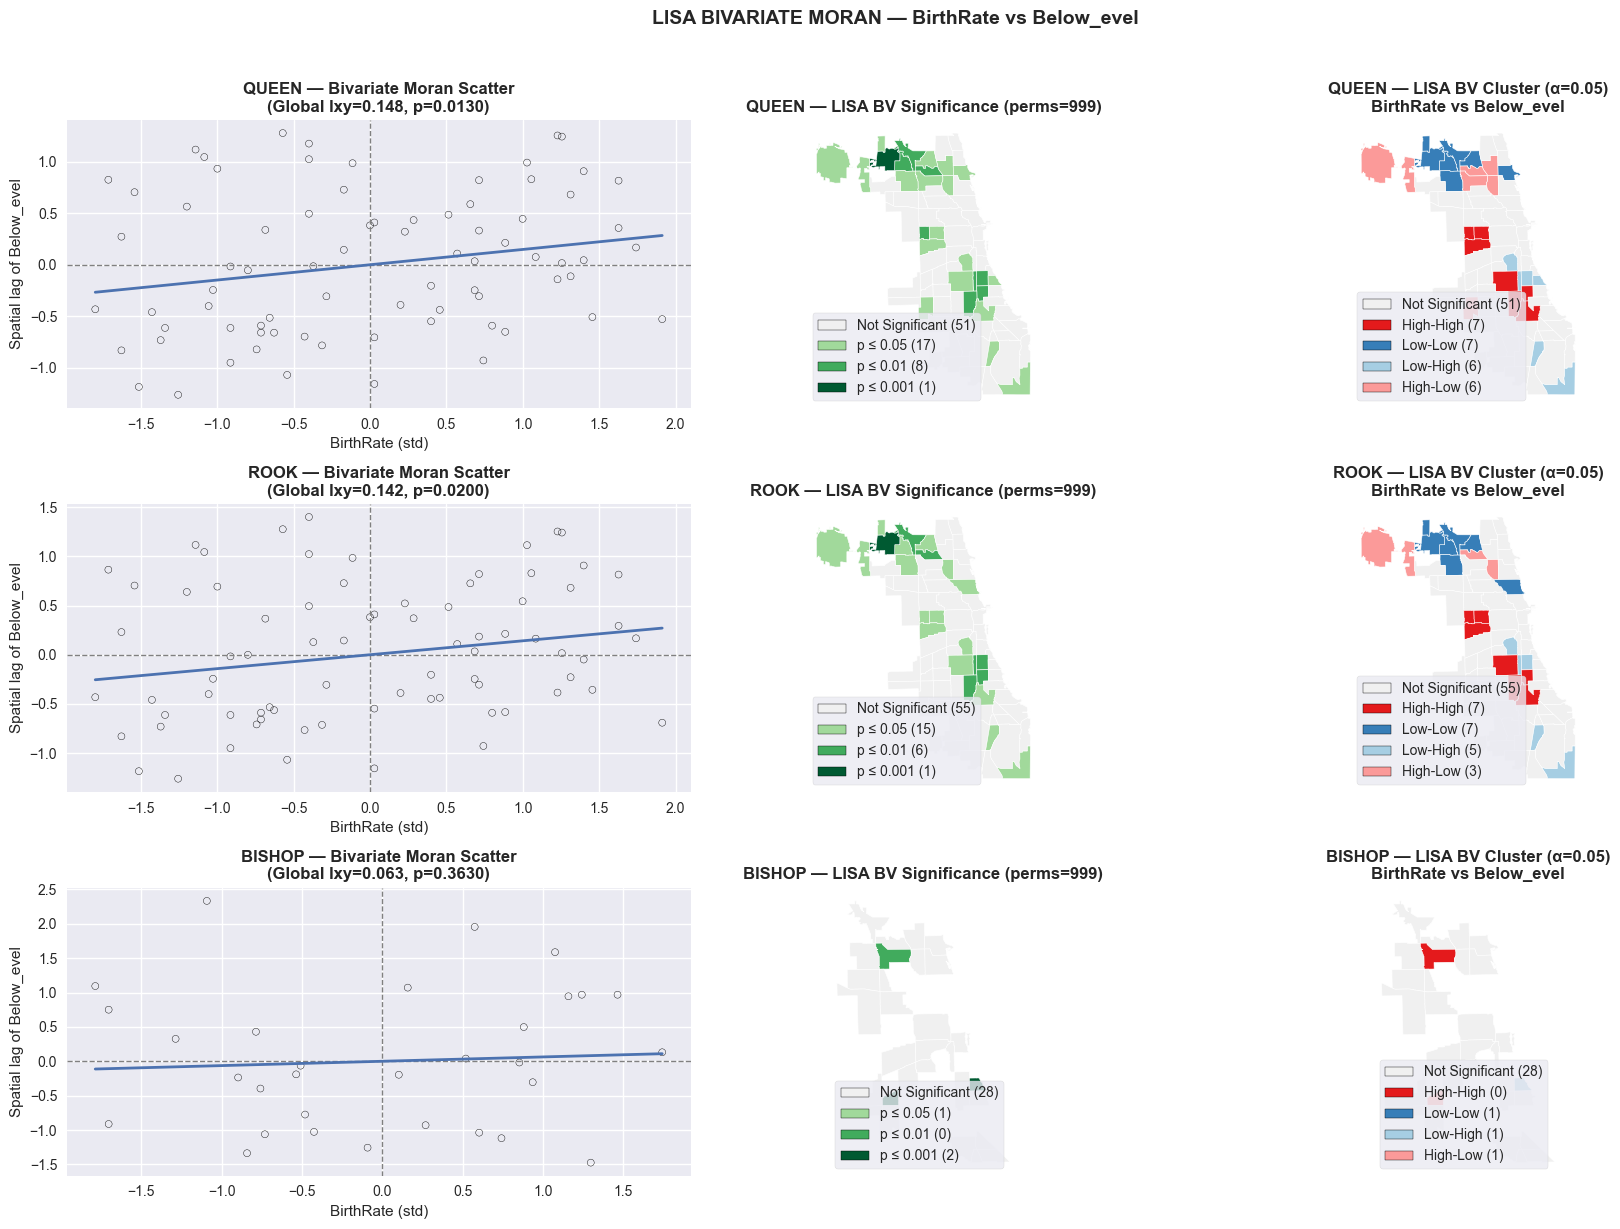

In [16]:
tab, fig, out = local_moran_bv(
    gdf=gdf,
    x_fields=["BirthRate"],
    y_fields=["Below_evel"],
    contiguities=("queen", "rook", "bishop"),
    permutations=999,
    alpha=0.05,
    standardize_xy=True,
    dashboard_pair=("BirthRate", "Below_evel"),
)

display(tab)
plt.show()

---